In [1]:
# PACKAGES
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import numpy as np
import ast
import os
import h5py
import scipy
import pandas as pd

from sklearn import metrics
from scipy import stats as ss
import matplotlib as mpl

%matplotlib inline

mpl.rcParams['font.size']=30
mpl.rcParams['font.family'] = 'Times New Roman'

from scipy import stats


C:\Users\nbbwang\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def str_to_param_dict(string):
    d = {}
    _,_,_,_,_,d["k_reg"],d["learning_rate"],_,d["grad_clip_norm"],_ = string.split("_")
    return d

In [3]:
path_to_results = "/Users/nbbwang/Documents/Lee Lab/AD_project/analyses/MTL_variable_tasks/6vars-continuous/origGE/"


dtype = "ACT_MSBBRNA_ROSMAP_PCASplit"
metric = "loss"

In [4]:
def get_CV_test_res_as_df(path_to_log_files):
    firstfile = os.listdir(path_to_log_files)[0]
    cols = pd.read_csv(path_to_log_files + firstfile).columns
    
    # save average performance of each CV fold for a given train/test split
    training_averages = []
    for i in range(5):
        all_vals = np.array([pd.read_csv(path_to_log_files + "%d.log"%((i*5)+j)).values for j in range(5)])
        training_averages.append(pd.DataFrame(np.nanmean(all_vals,axis=0), columns=cols))
    # save average performance across all CV folds for each train/test split 
    # (this could be used to select the hyperparameters for the final model but not for model evaluation purposes!)
    training_overall_averages = pd.DataFrame(np.nanmean(np.array([training_averages[i].values for i in range(5)]),axis=0), columns=cols)

    # save test performance measures
    test_runs = []
    for cur_idx in range(25,30):
        test_runs.append(pd.read_csv(path_to_log_files + "%d.log"%cur_idx))
    test_overall_averages = pd.DataFrame(np.nanmean(np.array([test_runs[i].values for i in range(5)]),axis=0), columns=cols)

    return training_averages, training_overall_averages, test_runs, test_overall_averages

In [5]:
def get_CV_test_error(path_to_results_folder, datatype, var, metric, MTL=True):
    
    hy_names = []
    tr_valid_vals_folds = []
    
    # loop through all hyperparameter combos
    files = os.listdir(path_to_results_folder + datatype)
    for fname in files:
        if MTL:
            cur_metric = var + "_out_" + metric
            path_to_log_files = path_to_results_folder + datatype+ "/"+fname+"/"
        else:
            cur_metric = metric
            path_to_log_files = path_to_results_folder + datatype+ "/"+fname+"/" + variable + "/"

        # get training performances 
        tr_runs, tr_av, test_runs, test_av = get_CV_test_res_as_df(path_to_log_files)
        
        hy_names.append(fname) 
        # for each train/test split, get average average CV score for the current set of hyperparameters
        tr_valid_vals_folds.append(np.array([tr_av_fold["val_" + cur_metric].values[-1] for tr_av_fold in tr_runs]))


    
    best_cases_test_performances = []
    best_case_test_performance_eps = []
    best_cases_parameters = []

    # get hyperparameter setting with lowest loss for each test fold 
    best_params_per_outerfold = np.argmin(np.array(tr_valid_vals_folds), axis=0)

    # loop through the five final test performances we get for each train/test split 
    for i, bestidx in enumerate(best_params_per_outerfold):

        if MTL:
            best_path = path_to_results_folder + datatype+ "/"+hy_names[bestidx]+"/"
        else:
            best_path = path_to_results_folder + datatype+ "/"+hy_names[bestidx]+"/" + variable + "/"
           
        tr_runs, tr_av, test_runs, test_av = get_CV_test_res_as_df(best_path)

        best_cases_test_performances.append(test_runs[i]["val_" + cur_metric].values[-1])
        best_case_test_performance_eps.append(np.argmin(test_runs[i]["val_" + cur_metric]))
        best_cases_parameters.append(hy_names[bestidx])

    return best_cases_test_performances,best_case_test_performance_eps,best_cases_parameters


## Store val and test set variances for MSE scaling

In [6]:
ALL_VARIANCES = {}
TOTAL_VARIANCES = {}


for variable in ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]:

    vars_by_split = []
    all_vals = np.array([])
    for fold_idx in range(30):
        path_to_preds_folder = path_to_results + "predictions/MTL/" + dtype + "/" 
        folder = os.listdir(path_to_preds_folder)[0]

        with h5py.File(path_to_preds_folder  + folder+"/" + "%d.h5"%fold_idx, 'r') as hf:
            true_plaques = hf["y_true"][variable][:]
        
        all_vals = np.append(all_vals, true_plaques)
        vars_by_split.append(np.nanvar(true_plaques))    
    variances = np.array(vars_by_split)
    ALL_VARIANCES[variable] = variances
    
    TOTAL_VARIANCES[variable] = np.nanvar(all_vals)
    
saved_vars = pd.DataFrame.from_dict(ALL_VARIANCES)
saved_vars.to_csv("test_set_variances.csv")

## create dict of test set performances for each model class

In [7]:
PERFORMANCE_VALS = {}
PERFORMANCE_VALS_list = {}
PERFORMANCE_SEMS = {}
best_hys = {}



for experiment in ["MTL", "MLP_Baselines", 'Linear_Baselines']:

    PERFORMANCE_VALS[experiment] = {}
    PERFORMANCE_VALS_list[experiment] = {}
    PERFORMANCE_SEMS[experiment] = {}
    best_hys[experiment] = {}

    
    path_to_results_folder = path_to_results + "results/" + experiment + "/"
    path_to_preds_folder = path_to_results + "predictions/" + experiment + "/"


    print(path_to_results_folder)


    for variable in ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "TAU_IHC", "ABETA_IHC"]:

        # get test results for each fold
        best_hy_test, best_hy_ep, best_hy = get_CV_test_error(path_to_results_folder,\
                dtype, variable, metric, MTL=(experiment=="MTL"))

        # get scaled average + std error for test performance
        mean_performance = np.round(np.mean(best_hy_test/ALL_VARIANCES[variable][25:]), 5)
        sem_performance = ss.sem(np.array(best_hy_test)/np.array(ALL_VARIANCES[variable][25:]))
        print(mean_performance, sem_performance)
        
        best_hys[experiment][variable] = best_hy
        PERFORMANCE_VALS[experiment][variable] = mean_performance
        PERFORMANCE_VALS_list[experiment][variable] = best_hy_test/ALL_VARIANCES[variable][25:]

        PERFORMANCE_SEMS[experiment][variable] = sem_performance
    

/Users/nbbwang/Documents/Lee Lab/AD_project/analyses/MTL_variable_tasks/6vars-continuous/origGE/results/MTL/
0.5608 0.024008406733295996
0.54685 0.027724780107494986
0.58248 0.02882595980396171
0.79203 0.04934868384751622
0.68215 0.07298986551381415
0.83618 0.02663018907654698
/Users/nbbwang/Documents/Lee Lab/AD_project/analyses/MTL_variable_tasks/6vars-continuous/origGE/results/MLP_Baselines/
0.60124 0.023554950974470884
0.62812 0.037624288550787276
0.62937 0.045664489349497524
1.05389 0.04463768353313495
0.79081 0.07865270053553088
0.92661 0.02532838207800487
/Users/nbbwang/Documents/Lee Lab/AD_project/analyses/MTL_variable_tasks/6vars-continuous/origGE/results/Linear_Baselines/
0.62399 0.026528314532884636
0.6245 0.01862288847599824
0.6241 0.017961273883681756
1.17843 0.09501333327981251
0.93597 0.033720291332642975
1.01209 0.032848352510879024


In [8]:
# generate table of selected hyperparameters 
df_contents=[]
for experiment in ["Linear_Baselines", "MLP_Baselines", "MTL"]:
    for variable in ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "TAU_IHC", "ABETA_IHC"]:
        for i,x in enumerate(best_hys[experiment][variable]):
            df_contents.append([experiment, variable, i] + list(str_to_param_dict(x).values()))
            

selected_hyperparams = pd.DataFrame(df_contents, columns=["experiment", "variable", "run"]+list(str_to_param_dict(x).keys()))
selected_hyperparams.to_csv("selected_hyperparameters.csv", index=False)

selected_hyperparams.head()

,experiment,variable,run,k_reg,learning_rate,grad_clip_norm
0,Linear_Baselines,CERAD,0,0.001000,0.000100,0.010000
1,Linear_Baselines,CERAD,1,0.001000,0.000100,0.010000
2,Linear_Baselines,CERAD,2,0.000010,0.000100,0.010000
3,Linear_Baselines,CERAD,3,0.000010,0.000100,0.100000
4,Linear_Baselines,CERAD,4,0.000010,0.000100,0.100000


In [9]:
# put results into format for easily generating figures 

experiments = ["Linear_Baselines", "MLP_Baselines", "MTL"]
VALUES = {}
STD_ERRS = {}
METRICS = {}

for pathology in ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]:
    VALUES[pathology] = []
    STD_ERRS[pathology] = []
    METRICS[pathology] = 'Mean Squared Error (scaled)'
    for experiment in experiments:
        VALUES[pathology].append(PERFORMANCE_VALS[experiment][pathology])
        STD_ERRS[pathology].append(PERFORMANCE_SEMS[experiment][pathology])

# generate paper figures

In [10]:
cmap = plt.cm.tab10
cmaplist = [cmap(i) for i in range(cmap.N)]

blue_plot = cmaplist[0]
green_plot= cmaplist[2]
red_plot= cmaplist[3]

['***', '***']
CERAD
['*', '*']
BRAAK
['', '']
PLAQUES
['**', '**']
TANGLES
['**', '*']
ABETA_IHC
['**', '']
TAU_IHC


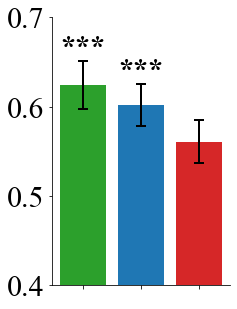

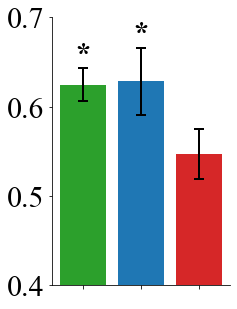

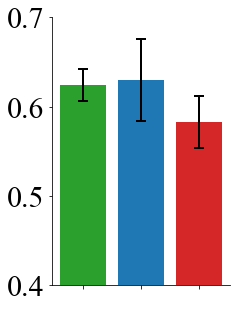

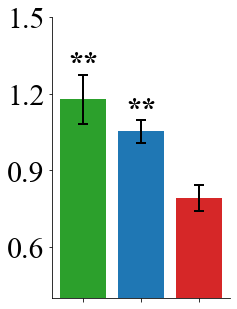

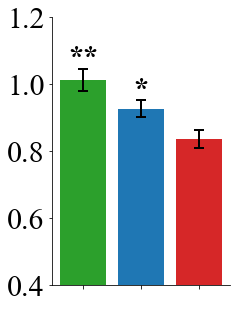

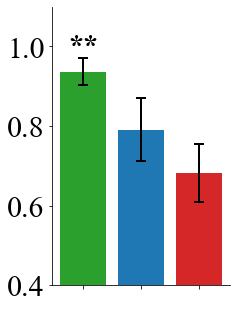

In [11]:
methods = ['Linear \nBaseline', 'MLP \nBaseline', 'MD-AD']
barcolor = plt.cm.Reds(.6)


x_pos = np.arange(len(methods))

# can use this code to try to generate upper limits for graph automatically
ylims = {}
for key in VALUES.keys():

    VAL_plus_STD = np.array(VALUES[key]) + np.array(STD_ERRS[key])
    upperlim = np.round(np.max(VAL_plus_STD), 1) 
    if key == "ABETA_IHC":
        upperlim += .05
    ylims[key] = (.4, upperlim)
    
# manually picked these upper limits for graph to make the figures look nice & clean
ylims = {"ABETA_IHC": 1.2, "TAU_IHC": 1.1, "PLAQUES": .7, "TANGLES": 1.5, "CERAD": .7, "BRAAK": .7}


for key in VALUES.keys():
    
    # generate annotations to test for significance between MTL and baselines 
    annots = []
    for exp in ["Linear_Baselines", "MLP_Baselines"]:
        t,p = stats.ttest_rel(PERFORMANCE_VALS_list["MTL"][key], PERFORMANCE_VALS_list[exp][key])
        if p/2 < .001:
            annots.append("***")
        elif p/2 < .01:
            annots.append("**")
        elif p/2 < .05:
            annots.append("*")
        else:
            annots.append("")
    print(annots)

    
    fig, ax = plt.subplots(figsize=(4,5))
    lin,mlp, mtl= ax.bar(x_pos, VALUES[key], yerr=STD_ERRS[key], align='center', alpha=1,  ecolor='black',
                         color=[green_plot, blue_plot, red_plot],error_kw=dict(lw=2, capsize=5, capthick=2))

    for i, txt in enumerate(annots):
        ann_x = x_pos[i]
        ann_y = VALUES[key][i] + STD_ERRS[key][i] + np.max(VALUES[key][i] + STD_ERRS[key][i])/100
        ax.text(ann_x,ann_y, txt, color='black', horizontalalignment ="center",fontweight="bold")
    
    for b in [lin,mlp,mtl]:
        b.set_edgecolor("None")
            
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels("")
    ax.set_ylim(.4,ylims[key])



    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if key in ["BRAAK", "CERAD", "PLAQUES"]:
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    else:
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax.set_facecolor('None')
    plt.tight_layout()
    print(key)

In [12]:
for phen in ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]:
    annots = []
    for exp in ["Linear_Baselines", "MLP_Baselines"]:
        t,p = stats.ttest_rel(-1*np.log10(PERFORMANCE_VALS_list["MTL"][phen]), -1*np.log10(PERFORMANCE_VALS_list[exp][phen]))
        if p/2 < .001:
            annots.append("***")
        elif p/2 < .01:
            annots.append("**")
        elif p/2 < .05:
            annots.append("*")
        else:
            annots.append("")
    print(annots)


['***', '***']
['*', '*']
['', '']
['**', '**']
['**', '*']
['*', '']


# calculating improvement percents:
This is for the paper, if we want to say "'MD-AD' provides a X percent reduction in error over the linear/mlp metod"

In [13]:
def get_percent_error_reduction(orig, new, pathology):
    return (PERFORMANCE_VALS[orig][pathology] - PERFORMANCE_VALS[new][pathology])/PERFORMANCE_VALS[orig][pathology]

In [14]:
for p in ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]:
    print(get_percent_error_reduction("MLP_Baselines", "MTL", p))

0.06726099394584531
0.1293861045660066
0.07450307450307449
0.24846995416979
0.09759229880963945
0.1374034218080196


In [15]:
for p in ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]:
    print(get_percent_error_reduction("Linear_Baselines", "MTL", p))

0.10126764852000845
0.12433947157726197
0.06668803076430058
0.3278938927216721
0.17380865338062812
0.2711839054670555
